# Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import random as rn
from IPython.display import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
%matplotlib inline

In [3]:
a = '/content/drive/MyDrive/' 
folder_name='/Transfer Learning_IIE4123' # Enter your own folder name !!!!!

path = a+folder_name

# Data

## Wafermap Data

- Classification

### Train data

In [103]:
groups_folder_path = path+'/data/Wafermap/'
# data path
categories = os.listdir(groups_folder_path)
# classes of images
num_classes = len(categories)
# number of classes

In [104]:
categories # classes of images

['Random',
 'Donut',
 'Scratch',
 'Near-Full',
 'Edge-loc',
 'None',
 'Loc',
 'Center',
 'Edge-ring']

In [105]:
size=64

In [106]:
# Image Loading
Y = [] # list of labels
X = [] # list of images
for idex, category in enumerate(categories):
    
    label = [0 for i in range(num_classes)]
    label[idex] = 1 # one-hot encoding
    image_dir = groups_folder_path + category + '/'
  
    for top, dir, f in os.walk(image_dir):
        print("Number of", category, len(f)) #409
        for filename in f:
            url = image_dir+filename # image path
            img = cv2.imread(url) # image read                      
            img = cv2.resize(img, dsize=(size,size), interpolation=cv2.INTER_NEAREST) # resizing
            X.append(img) # image append  
            Y.append(label) # label append

Number of Random 409
Number of Donut 409
Number of Scratch 409
Number of Near-Full 409
Number of Edge-loc 409
Number of None 409
Number of Loc 409
Number of Center 409
Number of Edge-ring 409


In [107]:
X=np.array(X)
Y=np.array(Y)

In [108]:
X.shape, Y.shape

((3681, 64, 64, 3), (3681, 9))

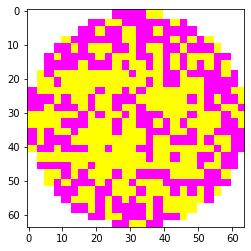

In [109]:
plt.imshow(X[0])

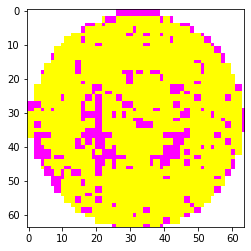

In [110]:
plt.imshow(X[600])

### Test Data

In [111]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42) # Stratified Sampling

In [112]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(2944, 64, 64, 3) (737, 64, 64, 3) (2944, 9) (737, 9)


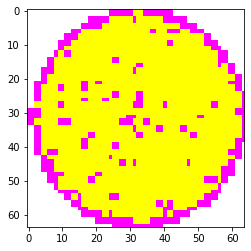

In [113]:
plt.imshow(X_test[0])

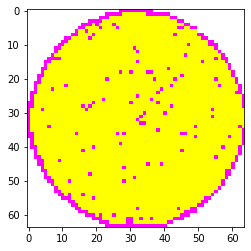

In [114]:
plt.imshow(X_test[5])

### Validation Data

In [115]:
test_images = np.array(X_test)
test_oh_labels = np.array(Y_test)

In [116]:
tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.25, random_state=42) # Stratified Sampling

In [117]:
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(2208, 64, 64, 3) (2208, 9) (736, 64, 64, 3) (736, 9) (737, 64, 64, 3) (737, 9)


In [118]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1/255.0)
valid_generator = ImageDataGenerator(rescale=1/255.0) # Generator (Preprocessing & Data augmentation)

In [119]:
BATCH_SIZE = 16

In [120]:
flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

# Transfer Learning

## VGG16

In [121]:
from tensorflow.keras.applications import VGG16
IMAGE_SIZE = 64
BATCH_SIZE = 16

### Only use model architecture
- Without using pretrained weight

In [23]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights=None, include_top=False) # weights=None
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5)(x)

# Number of output layer node = Number of classes
output = Dense(num_classes, activation='softmax', name='output')(x)


model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [25]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]

history = model.fit(flow_tr_gen, epochs=20, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
138/138 [==============================] - 15s 41ms/step - loss: 2.1180 - accuracy: 0.1341 - val_loss: 1.8874 - val_accuracy: 0.2853 - lr: 1.0000e-04
Epoch 2/20
138/138 [==============================] - 5s 38ms/step - loss: 1.9635 - accuracy: 0.2174 - val_loss: 1.8662 - val_accuracy: 0.2215 - lr: 1.0000e-04
Epoch 3/20
138/138 [==============================] - 5s 38ms/step - loss: 1.7721 - accuracy: 0.2736 - val_loss: 1.8235 - val_accuracy: 0.2364 - lr: 1.0000e-04
Epoch 4/20
138/138 [==============================] - 5s 38ms/step - loss: 1.6851 - accuracy: 0.3111 - val_loss: 1.5849 - val_accuracy: 0.3478 - lr: 1.0000e-04
Epoch 5/20
138/138 [==============================] - 5s 39ms/step - loss: 1.5602 - accuracy: 0.3569 - val_loss: 1.4342 - val_accuracy: 0.4212 - lr: 1.0000e-04
Epoch 6/20
138/138 [==============================] - 5s 39ms/step - loss: 1.4709 - accuracy: 0.3976 - val_loss: 1.3264 - val_accuracy: 0.4484 - lr: 1.0000e-04
Epoch 7/20
138/138 [===================

In [26]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

47/47 [==============================] - 1s 17ms/step - loss: 0.3751 - accuracy: 0.8833


[0.37511974573135376, 0.8833107352256775]

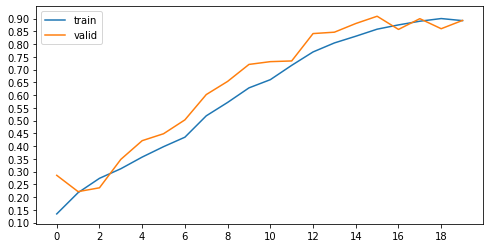

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

### Use Imagenet weights + Train the entire model

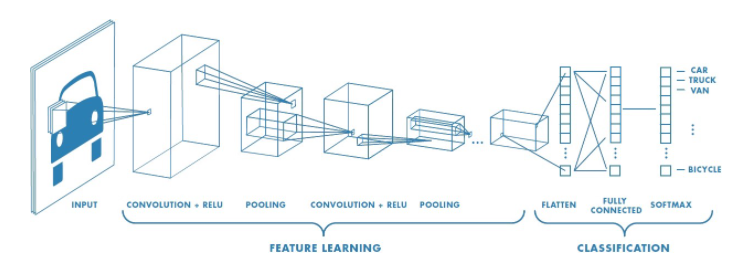

In [28]:
Image(path+'/img/05/f_e.png')

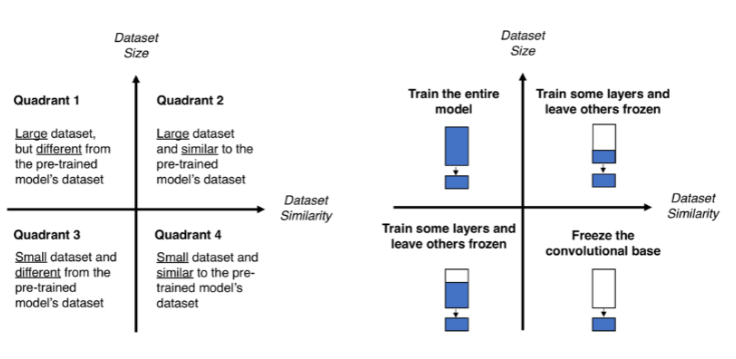

In [29]:
Image(path+'/img/05/transfer01.png')

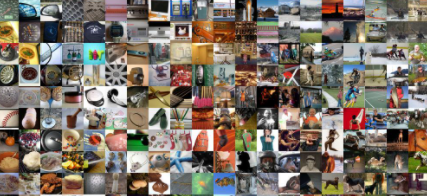

In [30]:
Image(path+'/img/05/imgnet.png')

In [31]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) #weights='imagenet'
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5)(x)
output = Dense(num_classes, activation='softmax', name='output')(x)


model = Model(inputs=base_model.input, outputs=output)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                            

In [32]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [33]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history = model.fit(flow_tr_gen, epochs=20, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
138/138 [==============================] - 7s 41ms/step - loss: 2.1593 - accuracy: 0.1726 - val_loss: 2.0533 - val_accuracy: 0.2894 - lr: 1.0000e-04
Epoch 2/20
138/138 [==============================] - 5s 39ms/step - loss: 1.8551 - accuracy: 0.2785 - val_loss: 1.8405 - val_accuracy: 0.3098 - lr: 1.0000e-04
Epoch 3/20
138/138 [==============================] - 5s 39ms/step - loss: 1.5994 - accuracy: 0.3949 - val_loss: 1.2794 - val_accuracy: 0.5489 - lr: 1.0000e-04
Epoch 4/20
138/138 [==============================] - 5s 40ms/step - loss: 1.2600 - accuracy: 0.5204 - val_loss: 0.9121 - val_accuracy: 0.6209 - lr: 1.0000e-04
Epoch 5/20
138/138 [==============================] - 5s 40ms/step - loss: 1.0423 - accuracy: 0.6096 - val_loss: 0.7236 - val_accuracy: 0.7758 - lr: 1.0000e-04
Epoch 6/20
138/138 [==============================] - 5s 40ms/step - loss: 0.8484 - accuracy: 0.6848 - val_loss: 0.4545 - val_accuracy: 0.8601 - lr: 1.0000e-04
Epoch 7/20
138/138 [====================

In [34]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

47/47 [==============================] - 1s 13ms/step - loss: 0.2472 - accuracy: 0.9593


[0.24716366827487946, 0.9592944383621216]

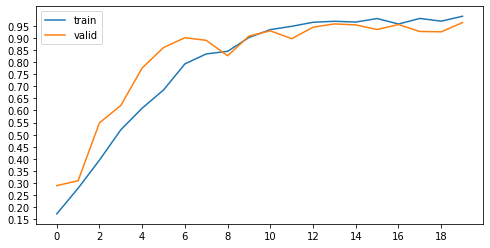

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

### Use Imagenet weights + Train some layers and leave others frozen

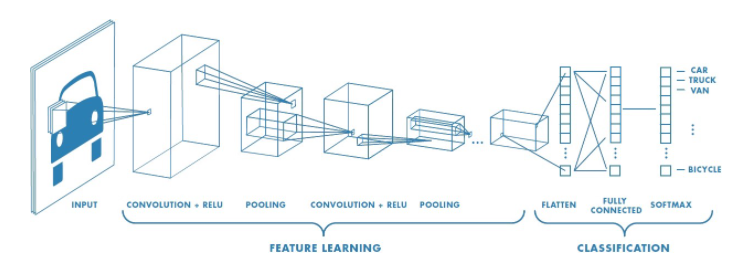

In [36]:
Image(path+'/img/05/f_e.png')

In [37]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5)(x)
output = Dense(num_classes, activation='softmax', name='output')(x)


model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [38]:
len(model.layers) # num of layers in model

24

In [39]:
model.layers

In [40]:
model.layers[:16]

In [41]:
fine_tune_at = 16

for layer in model.layers[:fine_tune_at]:
    layer.trainable =  False

In [42]:
display_layers = [(layer, layer.name, layer.trainable) for layer in model.layers]

pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_3,False
1,<keras.layers.convolutional.conv2d.Conv2D obje...,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D obje...,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling...,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D obje...,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D obje...,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling...,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D obje...,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D obje...,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D obje...,block3_conv3,False


In [43]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
 
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [44]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history = model.fit(flow_tr_gen, epochs=20, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
138/138 [==============================] - 4s 21ms/step - loss: 1.8942 - accuracy: 0.3279 - val_loss: 1.1113 - val_accuracy: 0.6902 - lr: 1.0000e-04
Epoch 2/20
138/138 [==============================] - 3s 20ms/step - loss: 1.1831 - accuracy: 0.5861 - val_loss: 0.7020 - val_accuracy: 0.7989 - lr: 1.0000e-04
Epoch 3/20
138/138 [==============================] - 3s 20ms/step - loss: 0.8456 - accuracy: 0.7034 - val_loss: 0.5352 - val_accuracy: 0.8274 - lr: 1.0000e-04
Epoch 4/20
138/138 [==============================] - 3s 20ms/step - loss: 0.7170 - accuracy: 0.7654 - val_loss: 0.4795 - val_accuracy: 0.8560 - lr: 1.0000e-04
Epoch 5/20
138/138 [==============================] - 3s 20ms/step - loss: 0.6064 - accuracy: 0.8043 - val_loss: 0.3917 - val_accuracy: 0.8927 - lr: 1.0000e-04
Epoch 6/20
138/138 [==============================] - 3s 20ms/step - loss: 0.5189 - accuracy: 0.8256 - val_loss: 0.3941 - val_accuracy: 0.8927 - lr: 1.0000e-04
Epoch 7/20
138/138 [====================

In [45]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

47/47 [==============================] - 1s 13ms/step - loss: 0.2321 - accuracy: 0.9322


[0.2321111559867859, 0.9321573972702026]

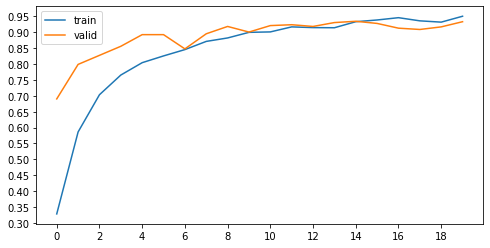

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

### 1- a) Three models use transfer learning differently. Please describe three models in the source code. 



1.   First model used a model architecutre without using pretrained weight.
2.   Second model used imagenet weights and train the entire model.
3.   Third model used imagenet weights and train some layers and leave others frozen. 



### 1 - b) Demonstrate the results of three models



1.   loss: 0.3913, accuracy: 0.9037
2.   loss: 0.1579, accuracy: 0.9756
3.   loss: 0.1660, accuracy: 0.9512



### 1 - c) According to (b), which of the three models has the best performance? What is the main reason that the model performs better?

The second model has the best performance since it has the highest accuracy. This is because the first model didn't use weights and the third model didn't train all layers

### 2 -a) Demonstrate the performance difference with/without dropout. Please try to make performance improvements using the proper dropout usage (you can adjust the percentage of dropout). You may need to show training and validation loss.

In [55]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) #weights='imagenet'
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5)(x)
output = Dense(num_classes, activation='softmax', name='output')(x)


model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [56]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [57]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history = model.fit(flow_tr_gen, epochs=20, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
138/138 [==============================] - 7s 41ms/step - loss: 2.0697 - accuracy: 0.2024 - val_loss: 1.6014 - val_accuracy: 0.4810 - lr: 1.0000e-04
Epoch 2/20
138/138 [==============================] - 5s 39ms/step - loss: 1.5532 - accuracy: 0.4289 - val_loss: 1.2612 - val_accuracy: 0.5584 - lr: 1.0000e-04
Epoch 3/20
138/138 [==============================] - 5s 40ms/step - loss: 1.2212 - accuracy: 0.5444 - val_loss: 0.8380 - val_accuracy: 0.6427 - lr: 1.0000e-04
Epoch 4/20
138/138 [==============================] - 6s 42ms/step - loss: 0.8259 - accuracy: 0.7115 - val_loss: 0.5650 - val_accuracy: 0.8288 - lr: 1.0000e-04
Epoch 5/20
138/138 [==============================] - 6s 40ms/step - loss: 0.5296 - accuracy: 0.8361 - val_loss: 0.3753 - val_accuracy: 0.8954 - lr: 1.0000e-04
Epoch 6/20
138/138 [==============================] - 5s 40ms/step - loss: 0.3466 - accuracy: 0.9004 - val_loss: 0.9655 - val_accuracy: 0.8261 - lr: 1.0000e-04
Epoch 7/20
138/138 [====================

In [58]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

47/47 [==============================] - 1s 13ms/step - loss: 0.2508 - accuracy: 0.9417


[0.25083214044570923, 0.9416553378105164]

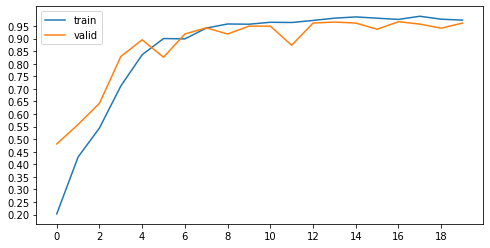

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

Model without last dropout layer

In [60]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) #weights='imagenet'
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
output = Dense(num_classes, activation='softmax', name='output')(x)


model_without_dropout = Model(inputs=base_model.input, outputs=output)
model_without_dropout.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [61]:
model_without_dropout.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [62]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history_without_dropout = model_without_dropout.fit(flow_tr_gen, epochs=20, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
138/138 [==============================] - 7s 41ms/step - loss: 1.2835 - accuracy: 0.5426 - val_loss: 0.4290 - val_accuracy: 0.8791 - lr: 1.0000e-04
Epoch 2/20
138/138 [==============================] - 5s 39ms/step - loss: 0.5585 - accuracy: 0.8184 - val_loss: 0.2626 - val_accuracy: 0.9144 - lr: 1.0000e-04
Epoch 3/20
138/138 [==============================] - 6s 41ms/step - loss: 0.3521 - accuracy: 0.8868 - val_loss: 0.2419 - val_accuracy: 0.9321 - lr: 1.0000e-04
Epoch 4/20
138/138 [==============================] - 5s 40ms/step - loss: 0.2141 - accuracy: 0.9361 - val_loss: 0.1768 - val_accuracy: 0.9457 - lr: 1.0000e-04
Epoch 5/20
138/138 [==============================] - 6s 40ms/step - loss: 0.1801 - accuracy: 0.9470 - val_loss: 0.1865 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 6/20
138/138 [==============================] - 6s 40ms/step - loss: 0.1690 - accuracy: 0.9447 - val_loss: 0.1561 - val_accuracy: 0.9457 - lr: 1.0000e-04
Epoch 7/20
138/138 [====================

In [63]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model_without_dropout.evaluate(flow_test_gen)

47/47 [==============================] - 1s 11ms/step - loss: 0.1665 - accuracy: 0.9634


[0.16653376817703247, 0.9633650183677673]

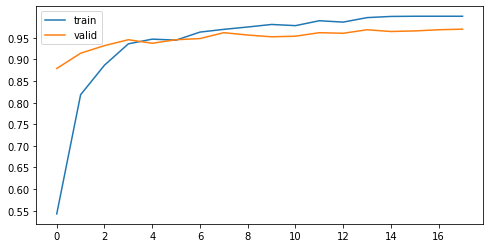

In [64]:
show_history(history_without_dropout)

Model without whole dropout layer

In [65]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) #weights='imagenet'
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
output = Dense(num_classes, activation='softmax', name='output')(x)


model_without_whole_dropout = Model(inputs=base_model.input, outputs=output)
model_without_whole_dropout.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [66]:
model_without_whole_dropout.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [67]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history_without_whole_dropout = model_without_whole_dropout.fit(flow_tr_gen, epochs=20, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
138/138 [==============================] - 7s 41ms/step - loss: 1.3018 - accuracy: 0.5303 - val_loss: 0.7404 - val_accuracy: 0.7582 - lr: 1.0000e-04
Epoch 2/20
138/138 [==============================] - 5s 40ms/step - loss: 0.5829 - accuracy: 0.8057 - val_loss: 0.2788 - val_accuracy: 0.9117 - lr: 1.0000e-04
Epoch 3/20
138/138 [==============================] - 5s 40ms/step - loss: 0.3281 - accuracy: 0.8981 - val_loss: 0.2106 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 4/20
138/138 [==============================] - 6s 40ms/step - loss: 0.2371 - accuracy: 0.9216 - val_loss: 0.3496 - val_accuracy: 0.8832 - lr: 1.0000e-04
Epoch 5/20
138/138 [==============================] - 6s 40ms/step - loss: 0.1869 - accuracy: 0.9411 - val_loss: 0.2511 - val_accuracy: 0.9185 - lr: 1.0000e-04
Epoch 6/20
138/138 [==============================] - 5s 40ms/step - loss: 0.1419 - accuracy: 0.9597 - val_loss: 0.2513 - val_accuracy: 0.9443 - lr: 1.0000e-04
Epoch 7/20
138/138 [====================

In [68]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model_without_whole_dropout.evaluate(flow_test_gen)

47/47 [==============================] - 1s 11ms/step - loss: 0.1838 - accuracy: 0.9661


[0.18376405537128448, 0.9660786986351013]

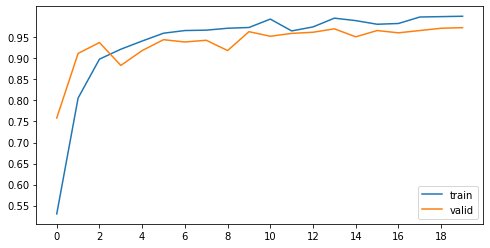

In [69]:
show_history(history_without_whole_dropout)

The model with dropout layer has the best performance. Even though the model without dropout layer has the highest accuracy(0.9661), the history graph shows that there could be overfitting in the model without dropout layer. Because validation and train don't converge, which means the model might be overfitted

### 2 - b) The goal is to improve test accuracy. Please demonstrate your experiments and specify how you achieve them.

In [122]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) #weights='imagenet'
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.6)(x)
output = Dense(num_classes, activation='softmax', name='output')(x)


model_dropout_6 = Model(inputs=base_model.input, outputs=output)
model_dropout_6.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [123]:
model_dropout_6.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [124]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history_dropout_6 = model_dropout_6.fit(flow_tr_gen, epochs=20, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
138/138 [==============================] - 6s 40ms/step - loss: 2.2294 - accuracy: 0.1245 - val_loss: 2.1701 - val_accuracy: 0.2120 - lr: 1.0000e-04
Epoch 2/20
138/138 [==============================] - 5s 39ms/step - loss: 2.1929 - accuracy: 0.1422 - val_loss: 2.1429 - val_accuracy: 0.2120 - lr: 1.0000e-04
Epoch 3/20
138/138 [==============================] - 5s 39ms/step - loss: 2.1324 - accuracy: 0.1993 - val_loss: 1.9444 - val_accuracy: 0.2486 - lr: 1.0000e-04
Epoch 4/20
138/138 [==============================] - 5s 39ms/step - loss: 2.1928 - accuracy: 0.1191 - val_loss: 2.1973 - val_accuracy: 0.1101 - lr: 1.0000e-04
Epoch 5/20
138/138 [==============================] - 5s 39ms/step - loss: 2.1974 - accuracy: 0.1051 - val_loss: 2.1973 - val_accuracy: 0.1101 - lr: 1.0000e-04
Epoch 6/20
138/138 [==============================] - 5s 39ms/step - loss: 2.1975 - accuracy: 0.1114 - val_loss: 2.1973 - val_accuracy: 0.1101 - lr: 1.0000e-04
Epoch 7/20
138/138 [====================

In [125]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model_dropout_6.evaluate(flow_test_gen)

47/47 [==============================] - 1s 11ms/step - loss: 2.1973 - accuracy: 0.1113


[2.1972835063934326, 0.11126187443733215]

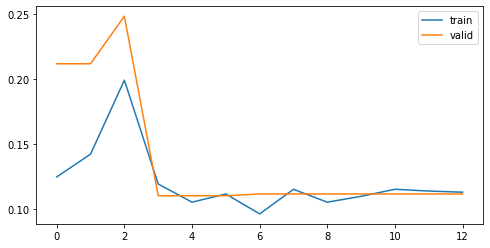

In [126]:
show_history(history_dropout_6)

In [127]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) #weights='imagenet'
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.6)(x)
output = Dense(num_classes, activation='softmax', name='output')(x)


model_lr_5 = Model(inputs=base_model.input, outputs=output)
model_lr_5.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [128]:
model_lr_5.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [129]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history_lr_5 = model_lr_5.fit(flow_tr_gen, epochs=20, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
138/138 [==============================] - 6s 40ms/step - loss: 2.2374 - accuracy: 0.1137 - val_loss: 2.1972 - val_accuracy: 0.1114 - lr: 5.0000e-04
Epoch 2/20
138/138 [==============================] - 5s 38ms/step - loss: 2.1976 - accuracy: 0.1082 - val_loss: 2.1972 - val_accuracy: 0.1114 - lr: 5.0000e-04
Epoch 3/20
138/138 [==============================] - 5s 38ms/step - loss: 2.1975 - accuracy: 0.1069 - val_loss: 2.1972 - val_accuracy: 0.1114 - lr: 5.0000e-04
Epoch 4/20
138/138 [==============================] - 5s 38ms/step - loss: 2.1975 - accuracy: 0.1055 - val_loss: 2.1972 - val_accuracy: 0.1114 - lr: 5.0000e-04
Epoch 5/20
138/138 [==============================] - 5s 38ms/step - loss: 2.1975 - accuracy: 0.0987 - val_loss: 2.1972 - val_accuracy: 0.1114 - lr: 5.0000e-04
Epoch 6/20
137/138 [============================>.] - ETA: 0s - loss: 2.1974 - accuracy: 0.1058
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
138/138 [==================

In [130]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model_lr_5.evaluate(flow_test_gen)

47/47 [==============================] - 1s 12ms/step - loss: 2.1972 - accuracy: 0.1113


[2.1972317695617676, 0.11126187443733215]

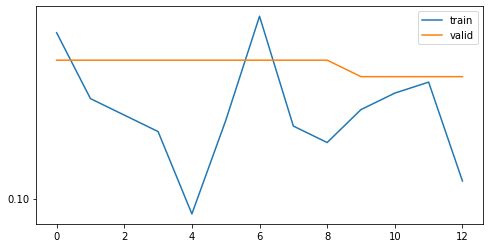

In [131]:
show_history(history_lr_5)

In [132]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) #weights='imagenet'
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.4)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.4)(x)
output = Dense(num_classes, activation='softmax', name='output')(x)


model_dropout_4 = Model(inputs=base_model.input, outputs=output)
model_dropout_4.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [133]:
model_dropout_4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [134]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history_dropout_4 = model_dropout_4.fit(flow_tr_gen, epochs=20, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
138/138 [==============================] - 6s 40ms/step - loss: 1.8684 - accuracy: 0.2826 - val_loss: 1.1949 - val_accuracy: 0.5666 - lr: 1.0000e-04
Epoch 2/20
138/138 [==============================] - 5s 39ms/step - loss: 1.1720 - accuracy: 0.5874 - val_loss: 0.4801 - val_accuracy: 0.8587 - lr: 1.0000e-04
Epoch 3/20
138/138 [==============================] - 5s 39ms/step - loss: 0.7298 - accuracy: 0.7749 - val_loss: 0.4174 - val_accuracy: 0.8859 - lr: 1.0000e-04
Epoch 4/20
138/138 [==============================] - 5s 39ms/step - loss: 0.4081 - accuracy: 0.8786 - val_loss: 0.4173 - val_accuracy: 0.8736 - lr: 1.0000e-04
Epoch 5/20
138/138 [==============================] - 5s 39ms/step - loss: 0.3637 - accuracy: 0.8954 - val_loss: 0.2852 - val_accuracy: 0.9090 - lr: 1.0000e-04
Epoch 6/20
138/138 [==============================] - 5s 39ms/step - loss: 0.2785 - accuracy: 0.9244 - val_loss: 0.3020 - val_accuracy: 0.9158 - lr: 1.0000e-04
Epoch 7/20
138/138 [====================

In [135]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model_dropout_4.evaluate(flow_test_gen)

47/47 [==============================] - 1s 11ms/step - loss: 0.1860 - accuracy: 0.9701


[0.18595153093338013, 0.9701492786407471]

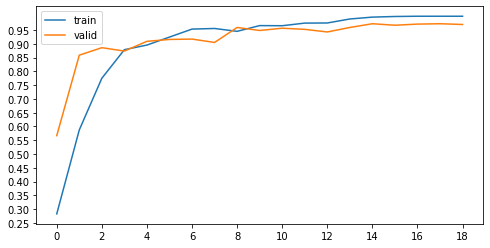

In [136]:
show_history(history_dropout_4)

In [137]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) #weights='imagenet'
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.3)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(num_classes, activation='softmax', name='output')(x)


model_dropout_3 = Model(inputs=base_model.input, outputs=output)
model_dropout_3.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [138]:
model_dropout_3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [139]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history_dropout_3 = model_dropout_3.fit(flow_tr_gen, epochs=20, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
138/138 [==============================] - 7s 41ms/step - loss: 1.3486 - accuracy: 0.5240 - val_loss: 0.6710 - val_accuracy: 0.7636 - lr: 1.0000e-04
Epoch 2/20
138/138 [==============================] - 6s 40ms/step - loss: 0.5983 - accuracy: 0.8043 - val_loss: 0.3630 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 3/20
138/138 [==============================] - 6s 40ms/step - loss: 0.4010 - accuracy: 0.8895 - val_loss: 0.3229 - val_accuracy: 0.9008 - lr: 1.0000e-04
Epoch 4/20
138/138 [==============================] - 6s 40ms/step - loss: 0.3001 - accuracy: 0.9103 - val_loss: 0.2813 - val_accuracy: 0.9185 - lr: 1.0000e-04
Epoch 5/20
138/138 [==============================] - 6s 40ms/step - loss: 0.1884 - accuracy: 0.9438 - val_loss: 0.1890 - val_accuracy: 0.9470 - lr: 1.0000e-04
Epoch 6/20
138/138 [==============================] - 5s 40ms/step - loss: 0.1698 - accuracy: 0.9493 - val_loss: 0.3635 - val_accuracy: 0.8832 - lr: 1.0000e-04
Epoch 7/20
138/138 [====================

In [140]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model_dropout_3.evaluate(flow_test_gen)

47/47 [==============================] - 1s 13ms/step - loss: 0.1942 - accuracy: 0.9647


[0.1942381113767624, 0.9647218585014343]

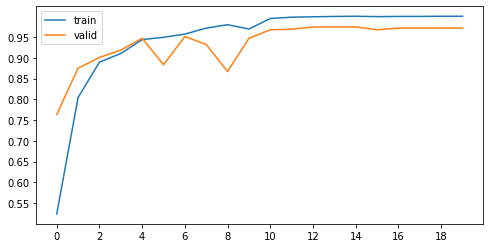

In [141]:
show_history(history_dropout_3)

In [142]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) #weights='imagenet'
bm_output = base_model.output

x = tf.keras.layers.GlobalMaxPool2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5)(x)
output = Dense(num_classes, activation='softmax', name='output')(x)


model_maxpool_lr5 = Model(inputs=base_model.input, outputs=output)
model_maxpool_lr5.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [143]:
model_maxpool_lr5.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [144]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history_maxpool_lr5 = model_maxpool_lr5.fit(flow_tr_gen, epochs=20, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
138/138 [==============================] - 7s 40ms/step - loss: 2.2443 - accuracy: 0.1128 - val_loss: 2.1973 - val_accuracy: 0.1114 - lr: 5.0000e-04
Epoch 2/20
138/138 [==============================] - 5s 38ms/step - loss: 2.1973 - accuracy: 0.1150 - val_loss: 2.1973 - val_accuracy: 0.1114 - lr: 5.0000e-04
Epoch 3/20
138/138 [==============================] - 5s 38ms/step - loss: 2.1975 - accuracy: 0.1146 - val_loss: 2.1973 - val_accuracy: 0.1114 - lr: 5.0000e-04
Epoch 4/20
138/138 [==============================] - 5s 38ms/step - loss: 2.1975 - accuracy: 0.1082 - val_loss: 2.1973 - val_accuracy: 0.1101 - lr: 5.0000e-04
Epoch 5/20
138/138 [==============================] - 5s 39ms/step - loss: 2.1974 - accuracy: 0.1082 - val_loss: 2.1973 - val_accuracy: 0.1114 - lr: 5.0000e-04
Epoch 6/20
137/138 [============================>.] - ETA: 0s - loss: 2.1976 - accuracy: 0.0999
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
138/138 [==================

In [145]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model_maxpool_lr5.evaluate(flow_test_gen)

47/47 [==============================] - 1s 12ms/step - loss: 2.1972 - accuracy: 0.1113


[2.1972296237945557, 0.11126187443733215]

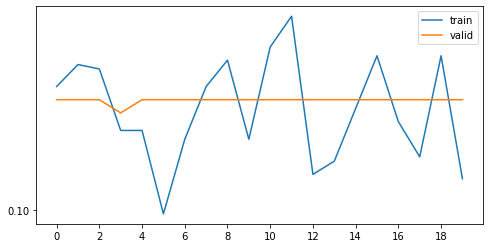

In [146]:
show_history(history_maxpool_lr5)

In [147]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) #weights='imagenet'
bm_output = base_model.output

x = tf.keras.layers.GlobalMaxPool2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5)(x)
output = Dense(num_classes, activation='softmax', name='output')(x)


model_maxpool = Model(inputs=base_model.input, outputs=output)
model_maxpool.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [148]:
model_maxpool.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [149]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history_maxpool = model_maxpool.fit(flow_tr_gen, epochs=20, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
138/138 [==============================] - 7s 41ms/step - loss: 2.0857 - accuracy: 0.2382 - val_loss: 1.6267 - val_accuracy: 0.4728 - lr: 1.0000e-04
Epoch 2/20
138/138 [==============================] - 5s 40ms/step - loss: 1.5243 - accuracy: 0.4325 - val_loss: 0.8827 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 3/20
138/138 [==============================] - 6s 41ms/step - loss: 1.1126 - accuracy: 0.5833 - val_loss: 0.6867 - val_accuracy: 0.7663 - lr: 1.0000e-04
Epoch 4/20
138/138 [==============================] - 5s 40ms/step - loss: 0.8636 - accuracy: 0.7092 - val_loss: 0.5004 - val_accuracy: 0.8043 - lr: 1.0000e-04
Epoch 5/20
138/138 [==============================] - 5s 39ms/step - loss: 0.5670 - accuracy: 0.8134 - val_loss: 0.3140 - val_accuracy: 0.9253 - lr: 1.0000e-04
Epoch 6/20
138/138 [==============================] - 5s 40ms/step - loss: 0.4275 - accuracy: 0.8655 - val_loss: 0.3085 - val_accuracy: 0.9008 - lr: 1.0000e-04
Epoch 7/20
138/138 [====================

In [150]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model_maxpool.evaluate(flow_test_gen)

47/47 [==============================] - 1s 11ms/step - loss: 0.1869 - accuracy: 0.9756


[0.1868724673986435, 0.975576639175415]

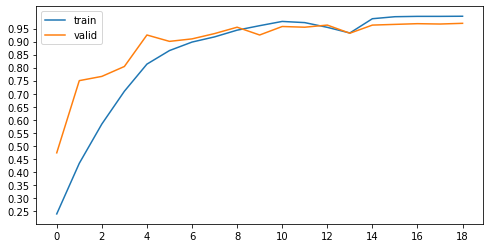

In [151]:
show_history(history_maxpool)

Using max pool, instead of using average pool, has the best performance. This is because there is a convergence between train and valid, and also it has great accuracy(0.9756)